In [1]:
cd '/root/Downloads/V/data'

/root/Downloads/V/data


In [2]:
ls

bottleneck_fc_model.h5        bottleneck_features_train.npy       test/   val/
bottleneck_features_test.npy  bottleneck_features_validation.npy  train/


In [3]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from tensorflow.keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense  
from tensorflow.keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import math  
import datetime
import time
import glob
from keras.layers import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import os
import tensorflow as tf


print('Tensorflow_VER= V',tf.version.VERSION)
print(confusion_matrix)

Tensorflow_VER= V 2.6.2
<function confusion_matrix at 0x7f5bd2c91a60>


In [4]:
#Feature Extraction cuy
img_width, img_height = 224, 224  

train_data_dir = '/root/Downloads/V/data/train/'  
test_data_dir = '/root/Downloads/V/data/test/'
validation_data_dir = '/root/Downloads/V/data/val/'

top_model_weights_path = 'bottleneck_fc_model_vgg16.h5' 

#TUNING SEBAGIAN DISINI
batch_size = 32
lr=1e-4
opt='rmsprop'
epochs = 2 
  

vgg16 = applications.VGG16(include_top=False, weights='imagenet') 
vgg16.summary() #Arsitekturnya Wan

datagen = ImageDataGenerator(rescale=1. / 255)  
train_datagen = ImageDataGenerator(#rescale=1. / 255) 
        rescale=1. / 255,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)    
#

#Pre train Training
start = datetime.datetime.now()
   
train_generator = train_datagen.flow_from_directory(  
      train_data_dir,  
      target_size=(img_width, img_height),  
      batch_size=batch_size,  
      class_mode=None,  
      shuffle=False)  
   
nb_train_samples = len(train_generator.filenames)  
num_classes = len(train_generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict_generator(train_generator, predict_size_train)     
np.save('/root/Downloads/V/data/bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

#Pre-train Validation cuy
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
      validation_data_dir,  
      target_size=(img_width, img_height),  
      batch_size=batch_size,  
      class_mode=None,  
      shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  

predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
      generator, predict_size_validation)  
   
np.save('/root/Downloads/V/data/bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

#Pre train Testing
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
      test_data_dir,  
      target_size=(img_width, img_height),  
      batch_size=batch_size,  
      class_mode=None,  
      shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict_generator(  
      generator, predict_size_test)  
   
np.save('/root/Downloads/V/data/bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

KeyboardInterrupt: 

In [5]:
#TRAINING dan Testing
from sklearn.metrics import confusion_matrix
#TRAINING
#hasil= []
#vgg16 = applications.vgg16(include_top=False, weights='imagenet') 

def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("confusion matrix yang dinormalisasi \n\n\n")
    else:
        print('Confusion matrix tanpa normalisasi \n\n\n')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


img_width, img_height = 224, 224  
top_model_weights_path = 'bottleneck_fc_model.h5' 

datagen = ImageDataGenerator(rescale=1. / 255) 
 
#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
train_data = np.load('/root/Downloads/V/data/bottleneck_features_train.npy')  
   
train_labels = generator_top.classes  
   
train_labels = to_categorical(train_labels, num_classes=num_classes) 

#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('/root/Downloads/V/data/bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

#Lanjut training 
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
#model.add(Dense(100, activation=LeakyReLU(alpha=0.3)))
model.add(Dense(100))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.5))  
#model.add(Dense(50, activation=LeakyReLU(alpha=0.3)))
model.add(Dense(50))
model.add(LeakyReLU(alpha=0.3))  
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))  

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=lr),
              metrics=['acc'])  


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('/root/Downloads/V/models/vgg16/best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# history = model.fit(train_data, train_labels,  
#       epochs=20,
#       batch_size=batch_size,  
#       validation_data=(test_data, test_labels))


history = model.fit(train_data, train_labels,  
      epochs=10,
      batch_size=batch_size,  
      validation_data=(test_data, test_labels),
      verbose=0,
      callbacks=[es, mc])    

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 test_data, test_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.4f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

#Model summary
model.summary()

#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

Evaluasi=model.evaluate(test_data, test_labels)
print(Evaluasi)


print('test data', test_data)
preds = np.round(model.predict(test_data),0) 
score = model.predict(test_data)
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded test_labels', preds)
#Model di save 
model.save('/root/Downloads/V/models/vgg16/model_{}E.h5'.format(len(acc)))

view = ['Benign','Malignant']
classification_metrics = metrics.classification_report(test_labels, preds, target_names=view, digits=4 )
print(classification_metrics)

#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it's categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)


Found 140000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")



Epoch 00001: val_acc improved from -inf to 0.94985, saving model to /root/Downloads/V/models/vgg16/best_model.h5

Epoch 00002: val_acc improved from 0.94985 to 0.98860, saving model to /root/Downloads/V/models/vgg16/best_model.h5

Epoch 00003: val_acc did not improve from 0.98860

Epoch 00004: val_acc did not improve from 0.98860

Epoch 00005: val_acc improved from 0.98860 to 0.99255, saving model to /root/Downloads/V/models/vgg16/best_model.h5

Epoch 00006: val_acc did not improve from 0.99255

Epoch 00007: val_acc improved from 0.99255 to 0.99285, saving model to /root/Downloads/V/models/vgg16/best_model.h5

Epoch 00008: val_acc did not improve from 0.99285

Epoch 00009: val_acc did not improve from 0.99285

Epoch 00010: val_acc did not improve from 0.99285
625/625 [==============================] - 2s 3ms/step - loss: 0.0319 - acc: 0.9898
[INFO] accuracy: 98.9750%
[INFO] Loss: 0.03192012757062912
Time:  0:10:51.958133
Model: "sequential"
____________________________________________

rounded test_labels [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
              precision    recall  f1-score   support

      Benign     0.9943    0.9851    0.9897     10000
   Malignant     0.9852    0.9944    0.9898     10000

   micro avg     0.9898    0.9898    0.9898     20000
   macro avg     0.9898    0.9897    0.9897     20000
weighted avg     0.9898    0.9898    0.9897     20000
 samples avg     0.9898    0.9898    0.9898     20000



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


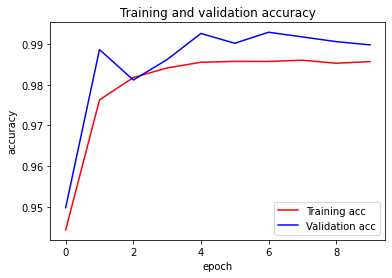

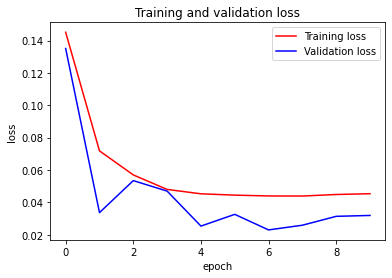

In [6]:
plotacc = plt.figure(1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plotacc.show()
plt.savefig("/root/Downloads/V/gambar/vgg16/train/Acc_vgg16_{}Batch_{}E_Opt={}_lr={}.jpg".format(batch_size, len(acc),opt,lr))

plotloss = plt.figure(2)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plotloss.show()
plt.savefig("/root/Downloads/V/gambar/vgg16/train/Loss_vgg16_{}Batch_{}E_Opt={}_lr={}.jpg".format(batch_size, len(acc),opt,lr))


Confusion matrix tanpa normalisasi 



confusion matrix yang dinormalisasi 





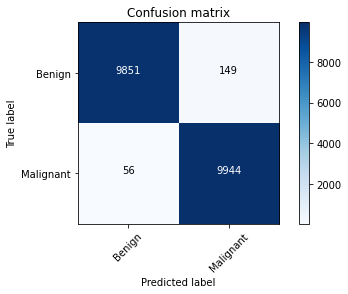

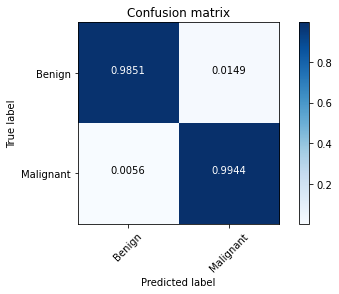

In [7]:
plotcmnn = plt.figure(3)    
plot_confusion_matrix(confusion_matrix, ['Benign','Malignant'])  
plt.savefig("/root/Downloads/V/gambar/vgg16/train/CMNN_vgg16_{}Batch_{}E_Opt={}_lr={}.jpg".format(batch_size, len(acc),opt,lr))

plotcmn = plt.figure(4) 
plot_confusion_matrix(confusion_matrix, ['Benign','Malignant'],normalize=True)
plt.savefig("/root/Downloads/V/gambar/vgg16/train/CMN_vgg16_{}Batch_{}E_Opt={}_lr={}.jpg".format(batch_size, len(acc),opt,lr))

In [8]:
#TESTING
from sklearn.metrics import confusion_matrix
#vgg16 = applications.vgg16(include_top=False, weights='imagenet')
 
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("confusion matrix yang dinormalisasi \n\n\n")
    else:
        print('Confusion matrix tanpa normalisasi \n\n\n')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def predict(path):
    view = ['Benign','Malignant']
    images = read_image(path)
#    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    preds = model.predict_proba(bt_prediction)
#    for idx, view, x in zip(range(0,6), view , preds[0]):
#        print("ID: {}, Label: {} {}%".format(idx, view, round(x*100,2) ))
#    print('Final Decision:')
#    time.sleep(.5)
#    for x in range(3):
#        print('.'*(x+1))
#        time.sleep(.2)
    class_predicted = model.predict_classes(bt_prediction)
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}  
#    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return load_img(path)

img_width, img_height = 224, 224  
top_model_weights_path = 'bottleneck_fc_model.h5' 

  
datagen = ImageDataGenerator(rescale=1. / 255) 

#training data
generator_top = datagen.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
train_data = np.load('/root/Downloads/V/data/bottleneck_features_train.npy')  

train_labels = generator_top.classes  
   
train_labels = to_categorical(train_labels, num_classes=num_classes) 

#validation data
generator_top = datagen.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('/root/Downloads/V/data/bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

#testing data
generator_top = datagen.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('/root/Downloads/V/data/bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)



 
#model = tf.keras.models.load_model('/content/gdrive/My Drive/CODE/models/vgg16/best_model.h5')
model = tf.keras.models.load_model('/root/Downloads/V/models/vgg16/best_model.h5')
model.summary()

model.evaluate(validation_data, validation_labels)

print('validation data', validation_data)
preds = np.round(model.predict(validation_data),0) 
score = model.predict(validation_data)
#to fit them into classification metrics and confusion metrics, some additional modificaitions are required
print('rounded validation_labels', preds)

view = ['Benign','Malignant']
classification_metrics = metrics.classification_report(validation_labels, preds, target_names=view, digits=4 )
print(classification_metrics)

categorical_validation_labels = pd.DataFrame(validation_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
confusion_matrix= confusion_matrix(categorical_validation_labels, categorical_preds)

Found 140000 images belonging to 2 classes.
Found 40000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               2508900   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0  

rounded validation_labels [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
              precision    recall  f1-score   support

      Benign     0.9914    0.9935    0.9924     20000
   Malignant     0.9935    0.9913    0.9924     20000

   micro avg     0.9924    0.9924    0.9924     40000
   macro avg     0.9924    0.9924    0.9924     40000
weighted avg     0.9924    0.9924    0.9924     40000
 samples avg     0.9924    0.9924    0.9924     40000



Confusion matrix tanpa normalisasi 



confusion matrix yang dinormalisasi 





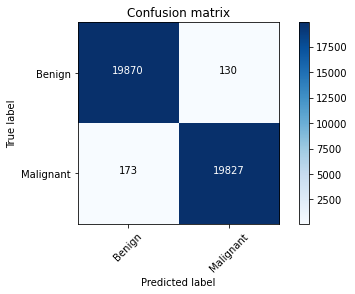

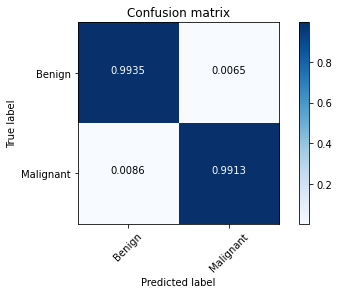

In [9]:
plotcmnn = plt.figure(5)    
plot_confusion_matrix(confusion_matrix, ['Benign','Malignant'])
plt.savefig("/root/Downloads/V/gambar/vgg16/test/CMNN_vgg16_{}Batch_{}E_Opt={}_lr={}.jpg".format(batch_size, len(acc),opt,lr))

plotcmn = plt.figure(6) 
plot_confusion_matrix(confusion_matrix, ['Benign','Malignant'],normalize=True)
plt.savefig("/root/Downloads/V/gambar/vgg16/test/CMN_vgg16_Normalized_{}Batch_{}E_Opt={}_lr={}.jpg".format(batch_size, len(acc),opt,lr))
# plt.savefig('gambar/vgg16/test/50e/CMN_vgg16_50E')